<a target="_blank" href="https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

If you have any problems opening it in colab, check the footer of this notebook.

# ISPR - Midterm 3 - Assignment 1: Denoising Autoencoder

*Author: Leonardo Crociani - Student ID: 615392*

I have aimed to make the code as self-explanatory as possible. The notebook includes both code and markdown explanations where necessary. I hope the work meets the requirements! 🙂

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load CIFAR-10 dataset from pickle files
def load_cifar10():
    x_train = []
    
    # Load training data from data batches
    for i in range(1, 6):
        batch_file = f'./CIFAR10/data_batch_{i}'
        batch_data = unpickle(batch_file)
        batch_images = batch_data[b'data']
        x_train.append(batch_images)
    
    x_train = np.vstack(x_train)
    
    # Load test data
    test_batch = unpickle('./CIFAR10/test_batch')
    x_test = test_batch[b'data']
    
    # Reshape data to image format (N, 32, 32, 3)
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # Normalize the data to be between 0 and 1
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    return x_train, x_test

# Load dataset
x_train, x_test = load_cifar10()

print('Training data shape:', x_train.shape)
print('Test data shape:', x_test.shape)


Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


First, we have to add some noise to the training data!

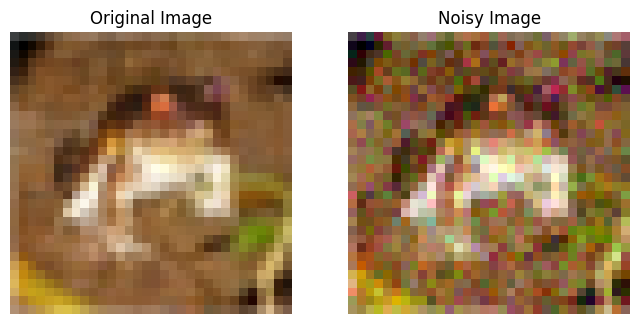

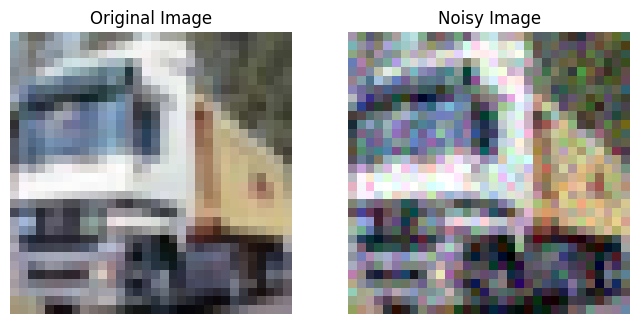

In [3]:
def add_noise(x_train, noise_factor=0.07):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    noisy_images = x_train + noise
    noisy_images = np.clip(noisy_images, 0., 1.) # the values must be clipped to be between 0 and 1
    return noisy_images

def plot_image(x_train, y_train, index):
    plt.figure(figsize=(8, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(x_train[index].reshape(32, 32, 3))
    plt.title('Original Image')
    plt.axis('off')
    
    # Noisy image
    plt.subplot(1, 2, 2)
    plt.imshow(y_train[index].reshape(32, 32, 3))
    plt.title('Noisy Image')
    plt.axis('off')
    
    plt.show()
    

y_train = add_noise(x_train)
plot_image(x_train, y_train, 0)
plot_image(x_train, y_train, 1)

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

Starting parallel grid search with 27 combinations...

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=128

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=128

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=128

Training model with: hidden_dims=[512, 256, 128], lr=0.001, batch_size=32
Epoch 1/500, Train Loss: 0.039455, Val Loss: 0.032998
Epoch 1/500, Train Loss: 0.044856, Val Loss: 0.034666
Epoch 1/500, Train Loss: 

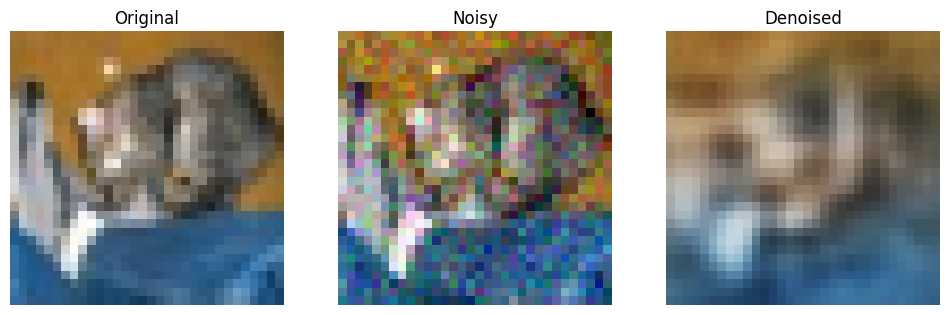

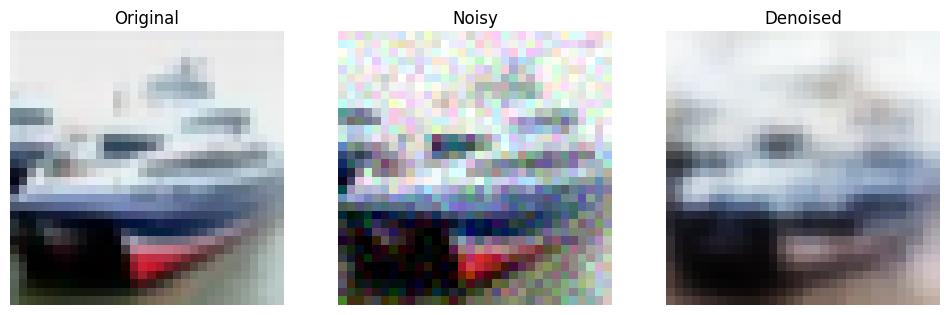

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import itertools
import numpy as np
import concurrent.futures
import copy

# Define the autoencoder architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self, hidden_dims=[1024, 512, 256, 128], input_size=3072):  # 32x32x3 = 3072
        super(DenoisingAutoencoder, self).__init__()
        
        # Build encoder layers dynamically
        encoder_layers = []
        prev_dim = input_size
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder layers dynamically (reverse of encoder)
        decoder_layers = []
        hidden_dims_reversed = hidden_dims[::-1]
        prev_dim = hidden_dims[-1]
        for i, dim in enumerate(hidden_dims_reversed[1:], 0):
            decoder_layers.append(nn.Linear(prev_dim, dim))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.5))
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_size))
        decoder_layers.append(nn.Sigmoid())  # Output values between 0 and 1
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.bottleneck_size = hidden_dims[-1]
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 32, 32, 3)  # Reshape back to image dimensions

# Prepare data for PyTorch
x_train_tensor = torch.FloatTensor(x_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)  # Noisy images as input
x_test_tensor = torch.FloatTensor(x_test).to(device)

# Create DataLoader for batch processing with validation split
def get_data_loaders(batch_size, val_split=0.2):
    train_dataset = TensorDataset(y_train_tensor, x_train_tensor)  # Input: noisy, Target: clean
    
    # Calculate split sizes
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    
    # Split the dataset
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# Training function with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        for noisy_imgs, clean_imgs in train_loader:
                # Zero the gradients
            optimizer.zero_grad()
                
                # Forward pass
            outputs = model(noisy_imgs)
                
                # Calculate loss
            loss = criterion(outputs, clean_imgs)
                
                # Backward pass and optimize
            loss.backward()
            optimizer.step()
                
                # Update running loss
            running_loss += loss.item()
                #pbar.set_postfix(loss=loss.item())
        
        # Calculate epoch training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                # Load the best model
                model.load_state_dict(best_model_state)
                break
    
    # If we completed all epochs without early stopping, ensure we use the best model
    if counter < patience and best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, best_val_loss

# Function to visualize results
def visualize_results(model, x_test, index=0):
    model.eval()
    with torch.no_grad():
        # Add noise to test image
        noisy_test = add_noise(x_test)
        noisy_img = torch.FloatTensor(noisy_test[index:index+1]).to(device)
        
        # Get denoised image
        denoised_img = model(noisy_img).cpu().numpy()[0]
        
        # Plot original, noisy, and denoised images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(x_test[index])
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(noisy_test[index])
        plt.title('Noisy')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img)
        plt.title('Denoised')
        plt.axis('off')
        
        plt.show()

# Function to train a single model with given parameters
def train_model_with_params(params):
    hidden_dims, lr, batch_size = params
    print(f"\nTraining model with: hidden_dims={hidden_dims}, lr={lr}, batch_size={batch_size}")
    
    # Create model with current parameters
    model = DenoisingAutoencoder(hidden_dims=hidden_dims).to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Get data loaders with current batch size
    train_loader, val_loader = get_data_loaders(batch_size)
    
    # Train the model with early stopping
    _, _, best_val_loss = train(model, train_loader, val_loader, criterion, optimizer, 
                               num_epochs=500, patience=5)
    
    print(f"Completed training with val_loss: {best_val_loss:.6f}")
    
    return {
        'hidden_dims': hidden_dims,
        'learning_rate': lr,
        'batch_size': batch_size,
        'val_loss': best_val_loss,
        'model_state': copy.deepcopy(model.state_dict())
    }

# Grid search parameters
param_grid = {
    'hidden_dims': [
        [1024, 512, 256, 128],
        [512, 256, 128],
        [2048, 1024, 512, 256]
    ],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
}

# Generate all parameter combinations
param_combinations = list(itertools.product(
    param_grid['hidden_dims'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
))

# Run parallel grid search
print(f"Starting parallel grid search with {len(param_combinations)} combinations...")
results = []

# Use ThreadPoolExecutor for parallelization
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Submit all parameter combinations to the executor
    future_to_params = {executor.submit(train_model_with_params, params): params 
                        for params in param_combinations}
    
    # Process results as they complete
    for future in concurrent.futures.as_completed(future_to_params):
        params = future_to_params[future]
        try:
            result = future.result()
            results.append(result)
            print(f"Completed: hidden_dims={params[0]}, lr={params[1]}, batch_size={params[2]}, val_loss={result['val_loss']:.6f}")
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

# Find best model
best_result = min(results, key=lambda x: x['val_loss'])

print("\nBest parameters:")
print(f"Hidden dimensions: {best_result['hidden_dims']}")
print(f"Learning rate: {best_result['learning_rate']}")
print(f"Batch size: {best_result['batch_size']}")
print(f"Best validation loss: {best_result['val_loss']:.6f}")

# Create and load the best model
best_model = DenoisingAutoencoder(hidden_dims=best_result['hidden_dims']).to(device)
best_model.load_state_dict(best_result['model_state'])

# Train the best model for more epochs
print("\nTraining best model with more epochs...")
best_train_loader, best_val_loader = get_data_loaders(best_result['batch_size'])
criterion = nn.MSELoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_result['learning_rate'])
train(best_model, best_train_loader, best_val_loader, criterion, best_optimizer, num_epochs=500, patience=5)

# Visualize results with the best model
visualize_results(best_model, x_test, index=0)
visualize_results(best_model, x_test, index=1)


In [17]:

# Prepare data for convolutional model (need to change format from NHWC to NCHW)
x_train_conv = np.transpose(x_train, (0, 3, 1, 2))  # Convert to (N, C, H, W)
y_train_conv = np.transpose(y_train, (0, 3, 1, 2))
x_test_conv = np.transpose(x_test, (0, 3, 1, 2))

# Convert to PyTorch tensors
x_train_tensor_conv = torch.FloatTensor(x_train_conv).to(device)
y_train_tensor_conv = torch.FloatTensor(y_train_conv).to(device)
x_test_tensor_conv = torch.FloatTensor(x_test_conv).to(device)

# Create dataset and loaders for convolutional model
def get_conv_data_loaders(batch_size, val_split=0.2):
    train_dataset = TensorDataset(y_train_tensor_conv, x_train_tensor_conv)  # Input: noisy, Target: clean
    
    # Calculate split sizes
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    
    # Split the dataset
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# %%
# Define the convolutional autoencoder architecture
class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(ConvDenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # First transposed convolutional block
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # Second transposed convolutional block
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # Third transposed convolutional block
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to visualize results for convolutional model
def visualize_conv_results(model, x_test_conv, index=0):
    model.eval()
    with torch.no_grad():
        # Add noise to test image
        noisy_test = add_noise(np.transpose(x_test_conv, (0, 2, 3, 1)))  # Convert to NHWC for noise addition
        noisy_test_conv = np.transpose(noisy_test, (0, 3, 1, 2))  # Convert back to NCHW
        noisy_img = torch.FloatTensor(noisy_test_conv[index:index+1]).to(device)
        
        # Get denoised image
        denoised_img = model(noisy_img).cpu().numpy()[0]
        
        # Convert to HWC for display
        denoised_img = np.transpose(denoised_img, (1, 2, 0))
        original_img = np.transpose(x_test_conv[index], (1, 2, 0))
        noisy_img_display = np.transpose(noisy_test_conv[index], (1, 2, 0))
        
        # Plot original, noisy, and denoised images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(noisy_img_display)
        plt.title('Noisy')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img)
        plt.title('Denoised')
        plt.axis('off')
        
        plt.show()

# %%
# Create and train the convolutional model
conv_model = ConvDenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.001)

# Get data loaders
train_loader, val_loader = get_conv_data_loaders(batch_size=64)

# Train the model
print("Training convolutional denoising autoencoder...")
train_losses, val_losses, best_val_loss = train(
    conv_model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=500, patience=5
)

Training convolutional denoising autoencoder...
Epoch 1/500, Train Loss: 0.016953, Val Loss: 0.010322
Epoch 2/500, Train Loss: 0.009101, Val Loss: 0.008394
Epoch 3/500, Train Loss: 0.007531, Val Loss: 0.006896
Epoch 4/500, Train Loss: 0.006721, Val Loss: 0.006420
Epoch 5/500, Train Loss: 0.006271, Val Loss: 0.006016
Epoch 6/500, Train Loss: 0.005972, Val Loss: 0.005730
Epoch 7/500, Train Loss: 0.005734, Val Loss: 0.005502
Epoch 8/500, Train Loss: 0.005541, Val Loss: 0.005385
Epoch 9/500, Train Loss: 0.005383, Val Loss: 0.005278
Epoch 10/500, Train Loss: 0.005255, Val Loss: 0.005128
Epoch 11/500, Train Loss: 0.005136, Val Loss: 0.005009
Epoch 12/500, Train Loss: 0.005029, Val Loss: 0.004988
Epoch 13/500, Train Loss: 0.004944, Val Loss: 0.004849
Epoch 14/500, Train Loss: 0.004867, Val Loss: 0.004951
Epoch 15/500, Train Loss: 0.004784, Val Loss: 0.004754
Epoch 16/500, Train Loss: 0.004722, Val Loss: 0.004628
Epoch 17/500, Train Loss: 0.004665, Val Loss: 0.004542
Epoch 18/500, Train Loss: 

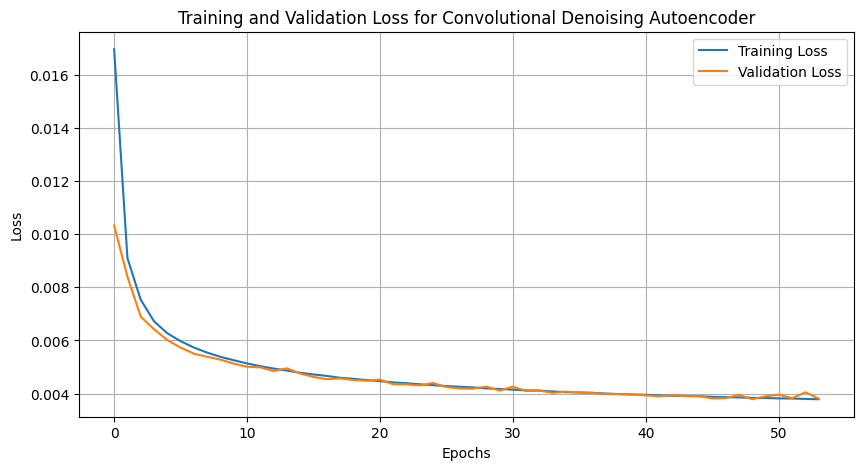

Visualizing results from convolutional model:


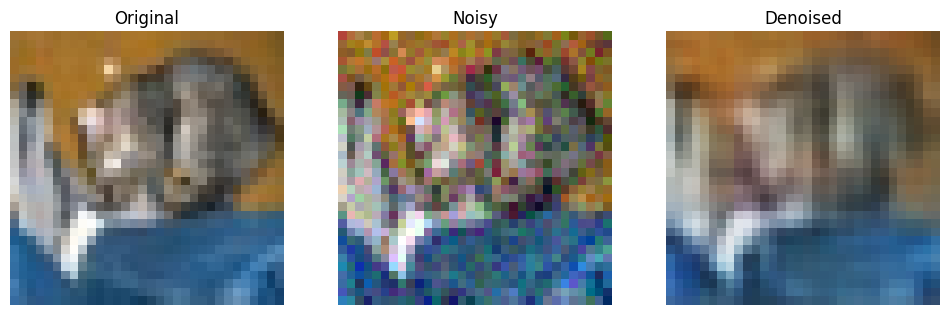

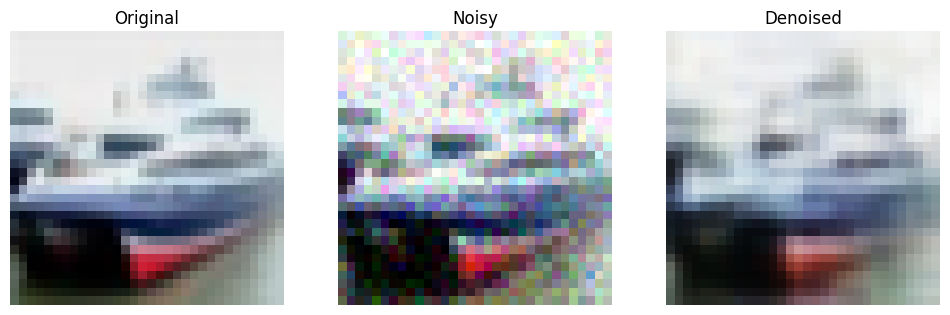

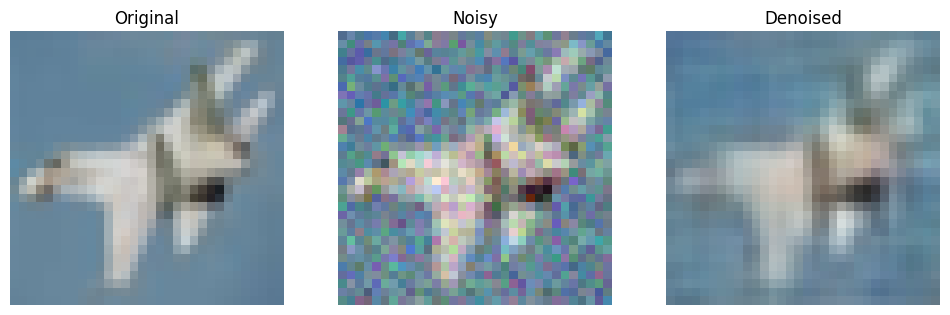

In [18]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Convolutional Denoising Autoencoder')
plt.legend()
plt.grid(True)
plt.show()

# Visualize results
print("Visualizing results from convolutional model:")
visualize_conv_results(conv_model, x_test_conv, index=0)
visualize_conv_results(conv_model, x_test_conv, index=1)
visualize_conv_results(conv_model, x_test_conv, index=10)


Fully Connected Autoencoder MSE: 0.005774
Convolutional Autoencoder MSE: 0.004002


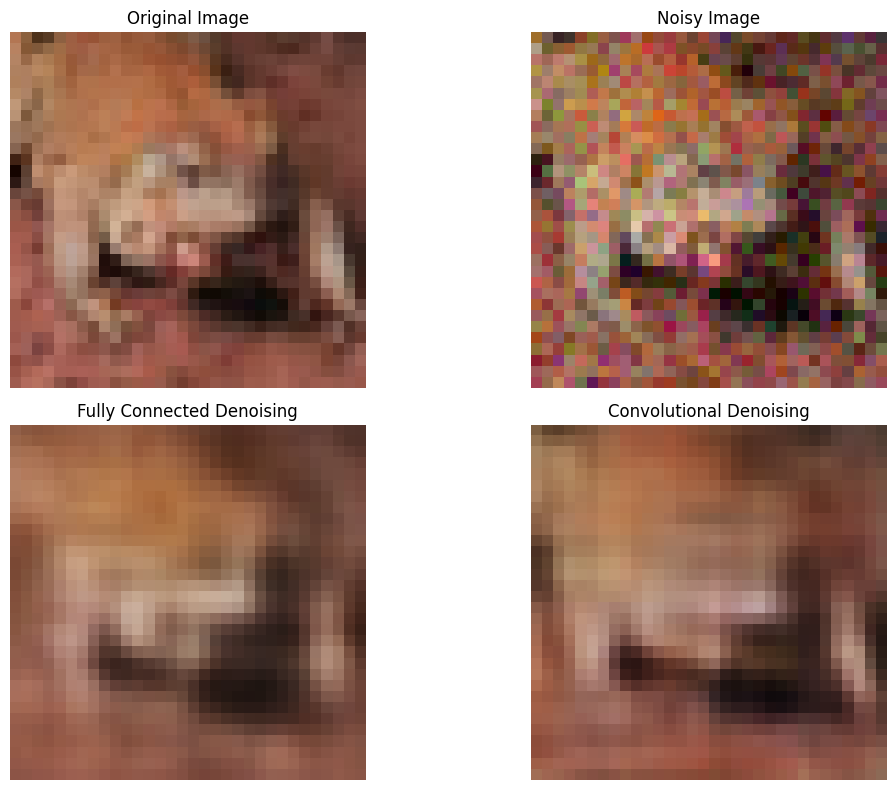

In [19]:

# %% [markdown]
# ## Comparing the Models
# 
# Let's compare the performance of the fully connected autoencoder with the convolutional autoencoder.

# %%
# Function to calculate MSE for a batch of images
def calculate_mse(model, images, is_conv=False):
    model.eval()
    with torch.no_grad():
        # Add noise to images
        if is_conv:
            # For convolutional model (NCHW format)
            images_nhwc = np.transpose(images, (0, 2, 3, 1))  # Convert to NHWC for noise addition
            noisy_images = add_noise(images_nhwc)
            noisy_images = np.transpose(noisy_images, (0, 3, 1, 2))  # Convert back to NCHW
            noisy_tensor = torch.FloatTensor(noisy_images).to(device)
            
            # Get denoised images
            denoised_images = model(noisy_tensor)
            
            # Calculate MSE
            original_tensor = torch.FloatTensor(images).to(device)
            mse = nn.MSELoss()(denoised_images, original_tensor).item()
        else:
            # For fully connected model (NHWC format)
            noisy_images = add_noise(np.transpose(images, (0, 2, 3, 1)))  # Convert to NHWC
            noisy_tensor = torch.FloatTensor(noisy_images).to(device)
            
            # Get denoised images
            denoised_images = model(noisy_tensor)
            
            # Calculate MSE
            original_tensor = torch.FloatTensor(np.transpose(images, (0, 2, 3, 1))).to(device)
            mse = nn.MSELoss()(denoised_images, original_tensor).item()
            
        return mse

# Calculate MSE for both models on test set
fc_mse = calculate_mse(best_model, x_test_conv[:100], is_conv=False)  # Use a subset for efficiency
conv_mse = calculate_mse(conv_model, x_test_conv[:100], is_conv=True)

print(f"Fully Connected Autoencoder MSE: {fc_mse:.6f}")
print(f"Convolutional Autoencoder MSE: {conv_mse:.6f}")

# Plot comparison of results
plt.figure(figsize=(12, 8))

# Select a test image
test_idx = 5

# Original image
original_img = np.transpose(x_test_conv[test_idx], (1, 2, 0))
plt.subplot(2, 2, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Noisy image
noisy_test = add_noise(np.transpose(x_test_conv, (0, 2, 3, 1)))
noisy_img = noisy_test[test_idx]
plt.subplot(2, 2, 2)
plt.imshow(noisy_img)
plt.title('Noisy Image')
plt.axis('off')

# Fully connected model result
with torch.no_grad():
    noisy_tensor = torch.FloatTensor(noisy_img[np.newaxis, ...]).to(device)
    fc_denoised = best_model(noisy_tensor).cpu().numpy()[0]
    
plt.subplot(2, 2, 3)
plt.imshow(fc_denoised)
plt.title('Fully Connected Denoising')
plt.axis('off')

# Convolutional model result
with torch.no_grad():
    noisy_test_conv = np.transpose(noisy_test, (0, 3, 1, 2))
    noisy_tensor = torch.FloatTensor(noisy_test_conv[test_idx:test_idx+1]).to(device)
    conv_denoised = conv_model(noisy_tensor).cpu().numpy()[0]
    conv_denoised = np.transpose(conv_denoised, (1, 2, 0))
    
plt.subplot(2, 2, 4)
plt.imshow(conv_denoised)
plt.title('Convolutional Denoising')
plt.axis('off')

plt.tight_layout()
plt.show()